(**Click the icon below to open this notebook in Colab**)

[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week08/notebook/demo.ipynb)

In [1]:
%%sh

ls -l work/2025-spring/week08/

total 4
-rw-r--r-- 1 jovyan users 476 Feb 25 03:21 README.md
drwxr-xr-x 4 jovyan users 128 Feb 26 21:58 data
drwxr-xr-x 3 jovyan users  96 Feb 25 03:19 notebook
drwxr-xr-x 2 jovyan users  64 Feb 25 03:19 pics


# Recap of Last Class

## Example - `prophet`

Prophet is an enhanced statistical tool because it extends traditional time series models with automated trend and seasonality detection, making it user-friendly and effective for business applications.

## Key Differences Between Holiday Effect and Seasonality  

| Feature            | Seasonality  | Holiday Effect |
|--------------------|-------------|---------------|
| **Definition**     | A **repeating pattern** that occurs at a fixed frequency (e.g., daily, weekly, yearly). | An impact on the time series caused by specific holidays or events. |
| **Regularity**     | **Strictly periodic** (e.g., weekly sales cycles, annual weather patterns). | **Not necessarily periodic** (holidays can fall on different weekdays each year). |
| **Examples**       | Increased ice cream sales in summer (yearly seasonality). Higher website traffic on weekends (weekly seasonality). | Lower stock market activity on Christmas. Higher online sales on Black Friday. |
| **Modeling in Prophet** | Modeled using a **Fourier series** to capture repeating cycles. | Modeled using **dummy variables** for specific dates, allowing deviations from normal patterns. |


In [2]:
import pandas as pd
from prophet import Prophet

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

Importing plotly failed. Interactive plots will not work.


In [3]:
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


The time series of the log daily page views for the Wikipedia page for Peyton Manning is used here
- https://facebook.github.io/prophet/docs/quick_start.html

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [5]:
m = Prophet(holidays=holidays)
m.fit(df)

future = m.make_future_dataframe(periods=365)
future.tail()

18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:10 - cmdstanpy - INFO - Chain [1] done processing


,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [6]:
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.217847,1.200633
2191,2014-02-03,1.898839,1.455819
2532,2015-01-11,1.217847,0.000000
2533,2015-01-12,1.898839,0.000000
2901,2016-01-17,1.217847,0.000000
2902,2016-01-18,1.898839,0.000000
2908,2016-01-24,1.217847,0.000000
2909,2016-01-25,1.898839,0.000000
2922,2016-02-07,1.217847,1.200633
2923,2016-02-08,1.898839,1.455819


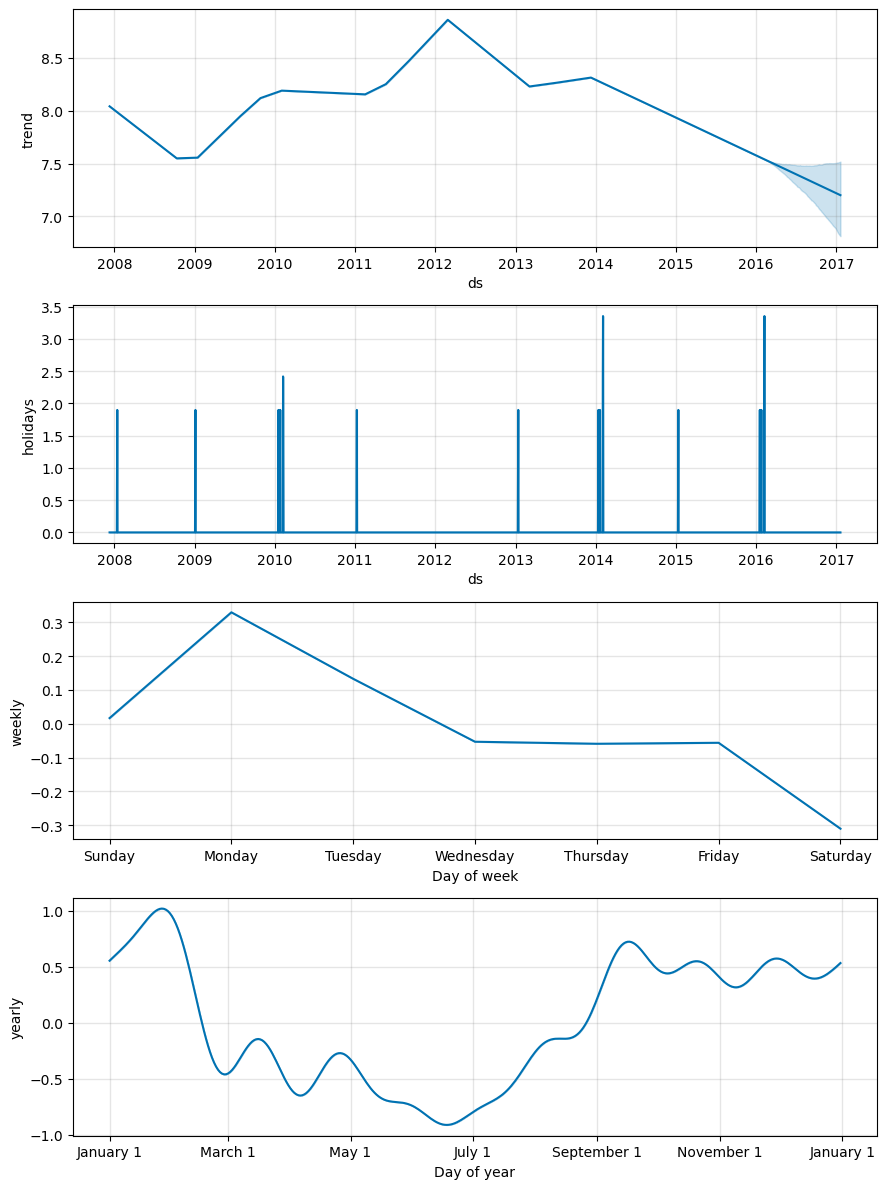

In [7]:
fig = m.plot_components(forecast)

## Example - `LSTM`

### Train the LSTM model

In [8]:
import matplotlib.pyplot as plt
import yfinance as yf

stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2025-01-31'

# Download historical data
df_aapl = yf.download(stock_symbol, start=start_date, end=end_date).Close.reset_index()
df_aapl.set_index('Date', inplace=True)
df_aapl.columns = ['Close']
df_aapl.head(10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Close
Date,
2020-01-02,72.716080
2020-01-03,72.009109
2020-01-06,72.582916
2020-01-07,72.241570
2020-01-08,73.403633
2020-01-09,74.962799
2020-01-10,75.132256
2020-01-13,76.737427
2020-01-14,75.701218


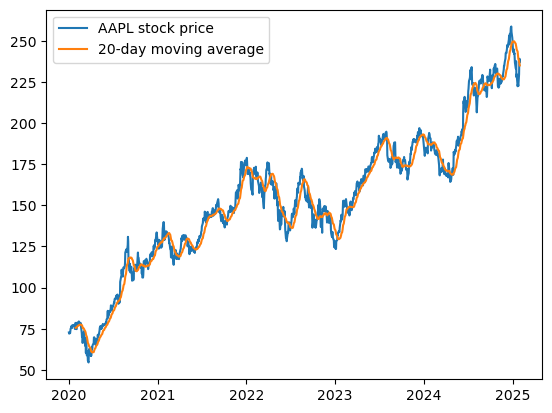

In [9]:
plt.plot(df_aapl.Close, label='AAPL stock price')
plt.plot(df_aapl.Close.rolling(20).mean(), label='20-day moving average')
plt.legend()
plt.show()

In [10]:
dataset_train = df_aapl.loc[:"2024-12-31", :].copy()
dataset_train.tail(3)

,Close
Date,
2024-12-27,255.309296
2024-12-30,251.923019
2024-12-31,250.144974


In [11]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set = dataset_train.Close.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [12]:
import numpy as np

X_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

2025-03-01 18:44:13.941320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - loss: 0.0849
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.0129
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 0.0068
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 0.0051
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0045
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0038
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.0044
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 0.0041
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0038
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0042
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 0.0040
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0044
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0044
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0034
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [16]:
import tensorflow as tf

tf.__version__

'2.18.0'

### Prediction

In [17]:
dataset_train.tail(3)

,Close
Date,
2024-12-27,255.309296
2024-12-30,251.923019
2024-12-31,250.144974


In [18]:
dataset_test = df_aapl.loc["2025-01-01":, :].copy()
pred_inputs = pd.concat(
    [
        dataset_train.iloc[-60:,:],
        dataset_test,
    ],
    axis=0
)
pred_inputs = pred_inputs.Close.values.reshape(-1, 1)
pred_inputs[:3]

array([[221.20315552],
       [225.27420044],
       [229.03591919]])

In [19]:
pred_inputs = sc.transform(pred_inputs)
X_test = []
for i in range(60, 80):
    X_test.append(pred_inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


In [20]:
dataset_test.shape

(19, 1)

In [21]:
predicted_stock_price = pd.DataFrame(predicted_stock_price[:19], index=dataset_test.index[:19], columns=['Close'])
predicted_stock_price.head(3)

,Close
Date,
2025-01-02,258.461700
2025-01-03,257.422607
2025-01-06,255.245682


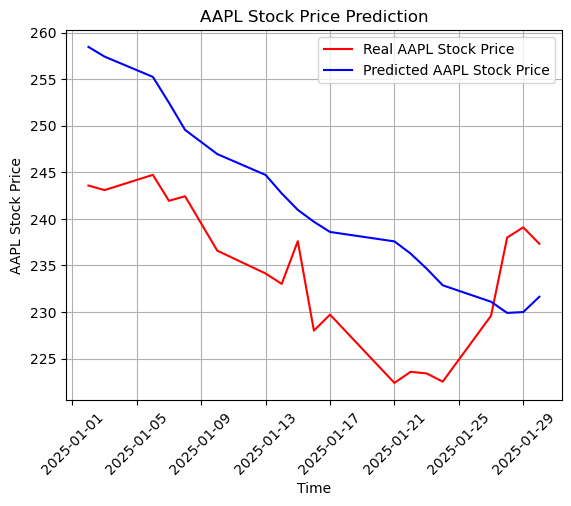

In [22]:
plt.plot(dataset_test[:19], color = 'red', label = 'Real AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows=None
pd.options.display.max_columns=None

# Clustering Methods

![](https://www.tutorialandexample.com/wp-content/uploads/2019/11/An-example-of-a-cluster-system.png)

![](https://fullcircle-cms.com/fullcircle/storage/uploads/2019/07/03/5d1ca1b9199dbClustering-GIF-2.gif)

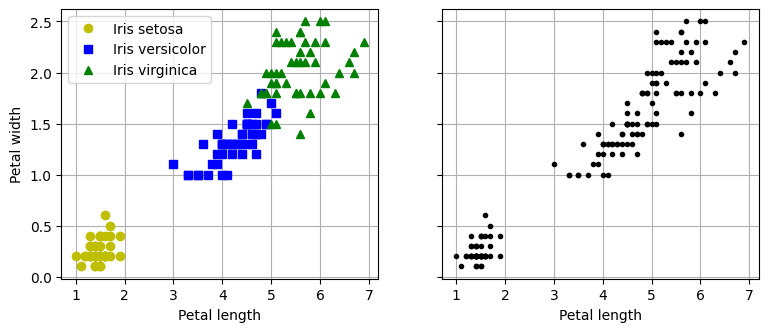

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

A Gaussian Mixture Model (GMM) assumes that the data is generated from a mixture of multiple Gaussian distributions (bell-shaped probability distributions). Instead of assigning data points to a single cluster with hard boundaries (like K-Means), GMM assigns a probability (soft assignment) to each data point for belonging to a cluster.

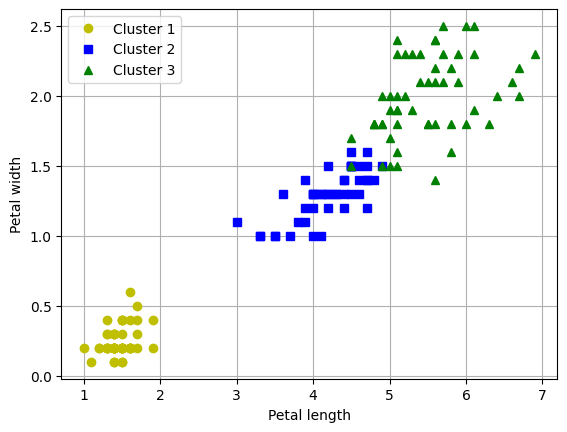

In [3]:
import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

mapping = {}
for cluster_id in np.unique(y_pred):
    most_common_class_id, _ = stats.mode(y[y_pred==cluster_id])
    mapping[cluster_id] = most_common_class_id

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.grid()
plt.show()

In [4]:
(y_pred==y).sum() / len(y_pred)


np.float64(0.9666666666666667)

**Clustering is used in a wide variety of applications**, including:

- Customer segmentation
    - You can cluster your customers based on their purchases and their activity on your website. This is useful to understand who your customers are and what they need, so you can adapt your products and marketing campaigns to each segment. For example, customer segmentation can be useful in recommender systems to suggest content that other users in the same cluster enjoyed.

- Data analysis
    - When you analyze a new dataset, it can be helpful to run a clustering algorithm, and then analyze each cluster separately.

- Dimensionality reduction
    - Once a dataset has been clustered, it is usually possible to measure each instance’s affinity with each cluster; affinity is any measure of how well an instance fits into a cluster. Each instance’s feature vector x can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k-dimensional. The new vector is typically much lower-dimensional than the original feature vector, but it can preserve enough information for further processing.

- Feature engineering
    - The cluster affinities can often be useful as extra features. For example, we used k-means in Chapter 2 to add geographic cluster affinity features to the California housing dataset, and they helped us get better performance.

- Anomaly detection (also called outlier detection)
    - Any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clustered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual number of requests per second.

- Semi-supervised learning
    - If you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster. This technique can greatly increase the number of labels available for a subsequent supervised learning algorithm, and thus improve its performance.

- Search engines
    - Some search engines let you search for images that are similar to a reference image. To build such a system, you would first apply a clustering algorithm to all the images in your database; similar images would end up in the same cluster. Then when a user provides a reference image, all you’d need to do is use the trained clustering model to find this image’s cluster, and you could then simply return all the images from this cluster.

- Image segmentation
    - By clustering pixels according to their color, then replacing each pixel’s color with the mean color of its cluster, it is possible to considerably reduce the number of different colors in an image. Image segmentation is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object.

## k-Means clustering

### The algorithm
* The model training process
![](https://stanford.edu/~cpiech/cs221/img/kmeansViz.png)

* Pseudo code:
![](https://stanford.edu/~cpiech/cs221/img/kmeansMath.png)

* The model training process (dynamic demonstration)
![](https://miro.medium.com/max/1280/1*rwYaxuY-jeiVXH0fyqC_oA.gif)

### Fit and predict

* Reference on function `make_blobs`: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

In [5]:
## generate some sample data

from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=123)

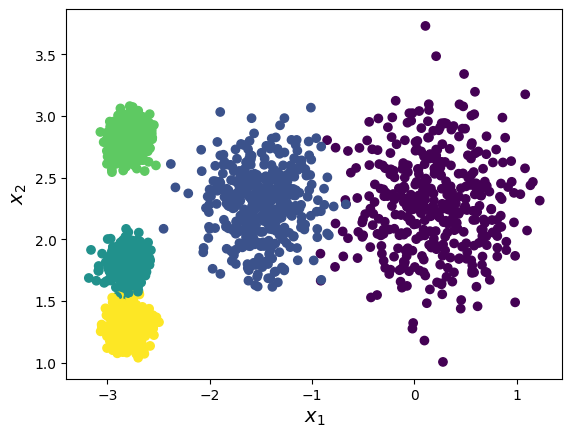

In [7]:
## plot the sample data

plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.show()

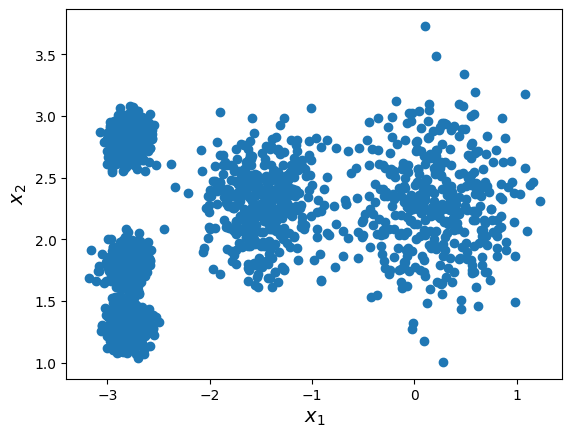

In [8]:
plt.scatter(X[:,0], X[:,1])
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.show()

In [9]:
## Fit a K-Means clustering model

from sklearn.cluster import KMeans


k = 5
kmeans = KMeans(n_clusters=k, random_state=123)
# kmenas.fit(X)
# y_pred = kmeans.predict(X)
y_pred = kmeans.fit_predict(X)

In [10]:
kmeans.labels_

array([1, 3, 2, ..., 2, 2, 2], shape=(2000,), dtype=int32)

In [11]:
kmeans.cluster_centers_

array([[-2.7979204 ,  2.80239567],
       [-0.10450921,  2.36430934],
       [-2.80100569,  1.55923795],
       [-1.47500483,  2.28212281],
       [ 0.53323641,  2.21720054]])

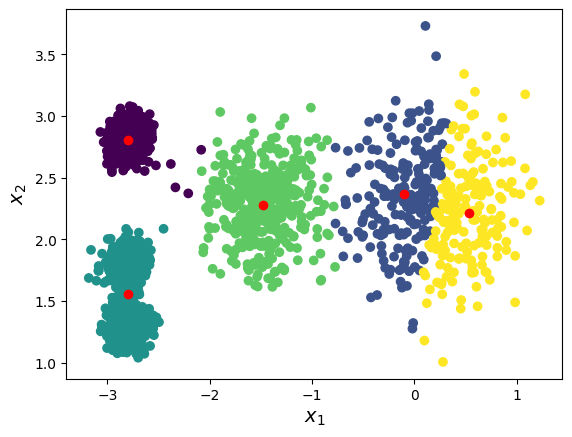

In [12]:
## plot the estimated centroids with the raw data

plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='r')
    
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.show()

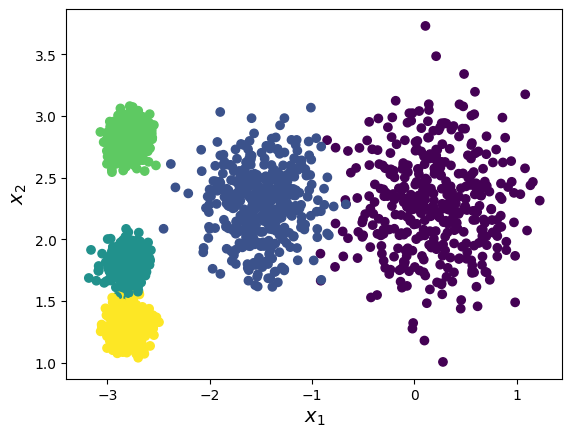

In [13]:
## plot the sample data

plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.show()

In [14]:
## predict labels of new instances

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 4, 0, 0], dtype=int32)

In [15]:
kmeans.transform(X_new)

array([[2.91070393, 0.37900326, 2.83547246, 1.50174317, 0.57577526],
       [5.85318031, 3.12581169, 5.8177262 , 4.48388911, 2.47630747],
       [0.28263694, 2.96445096, 1.45443942, 1.68551414, 3.61891345],
       [0.36370222, 2.89866846, 0.96157785, 1.54048068, 3.54453595]])

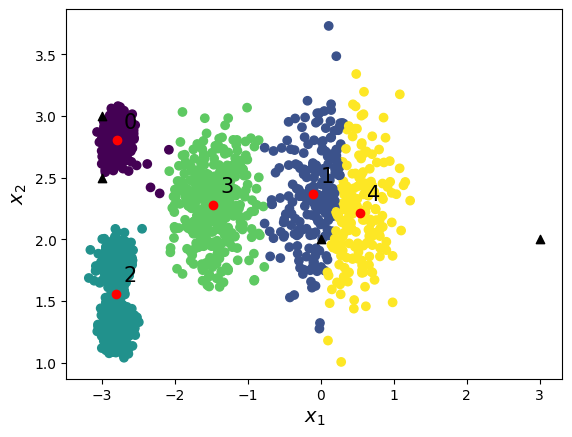

In [16]:
## visualize the new data points

plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='r')
plt.scatter(X_new[:,0], X_new[:,1], marker='^', c='k')


#### label the clusters
centers = kmeans.cluster_centers_
labels = kmeans.predict(centers)
for i in range(5):
    plt.text(centers[i][0]+0.1, centers[i][1]+0.1, labels[i], fontsize=15)

plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.show()

### The decision boundaries (the `voronoi diagram`)

In [17]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=2,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

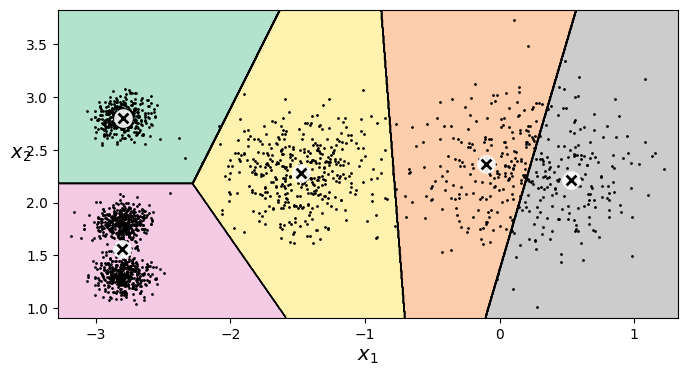

In [18]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

### The algorithm demonstration

* Initialize the centroids randomly

In [19]:
## run the kmeans algorithm 1, 2, and 3 iterations, see how the centroids move around

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="lloyd", max_iter=1, random_state=123)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="lloyd", max_iter=2, random_state=123)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="lloyd", max_iter=3, random_state=123)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=123)

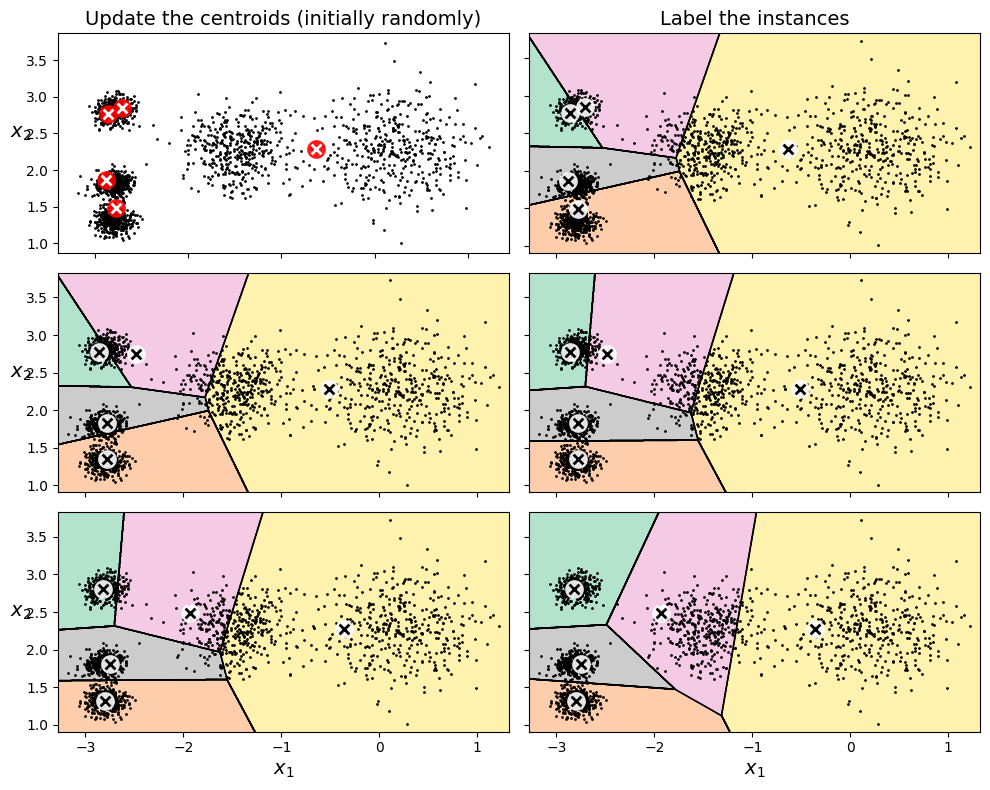

In [20]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.tight_layout()
plt.show()

* Depending on the centroids initialization, the model might converge to different solutions (different local optimums)

In [21]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

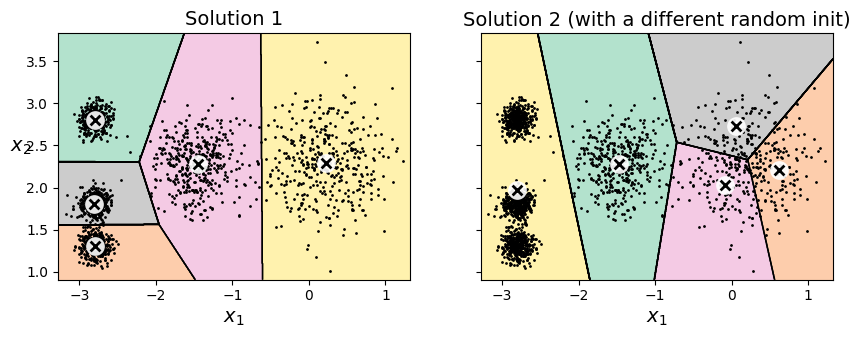

In [22]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=123)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=1)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

* Random number generator and seed

In [23]:
np.random.randint(low=0, high=3, size=5)

array([1, 2, 2, 0, 1])

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the `inertia` metric: **sum of the squared distances between each training instance and its closest centroid**.

In [24]:
from sklearn.cluster import KMeans


k = 5
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(X)
kmeans.inertia_

220.0898611212719

In [25]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=123)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=1)

kmeans_rnd_init1.fit(X)
kmeans_rnd_init2.fit(X)

kmeans_rnd_init1.inertia_, kmeans_rnd_init2.inertia_

(210.3191547116946, 606.6251155359678)

In [26]:
kmeans.score(X) # the negative inertia

-220.0898611212719

In [28]:
## multiple randomization

k = 5
kmeans_10 = KMeans(n_clusters=k, n_init=10)
kmeans_10.fit(X)
kmeans_10.inertia_

210.31915471169458

In [29]:
## manually assign initial centroids

good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans_m = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans_m.fit(X)
kmeans_m.inertia_

210.31915471169458

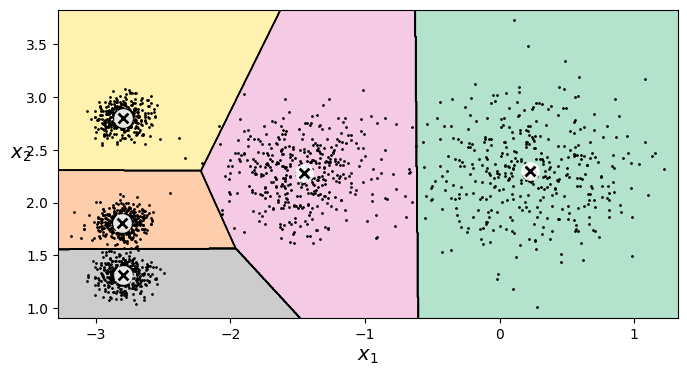

In [30]:
## visualize the best model

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_10, X)
plt.show()

### Find the optimal number of clusters - the "elbow" plot

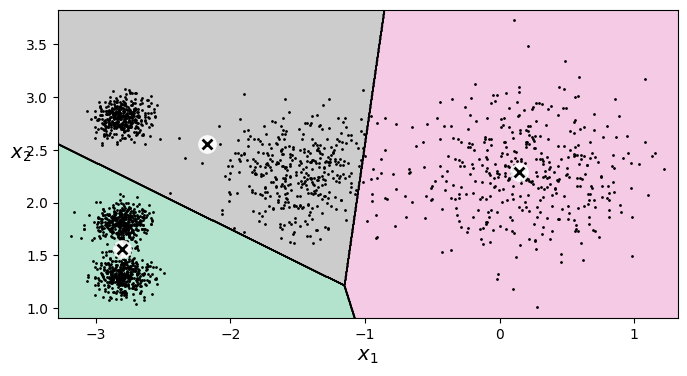

In [31]:
## visualize k = 4
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X)


plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_3, X)
plt.show()

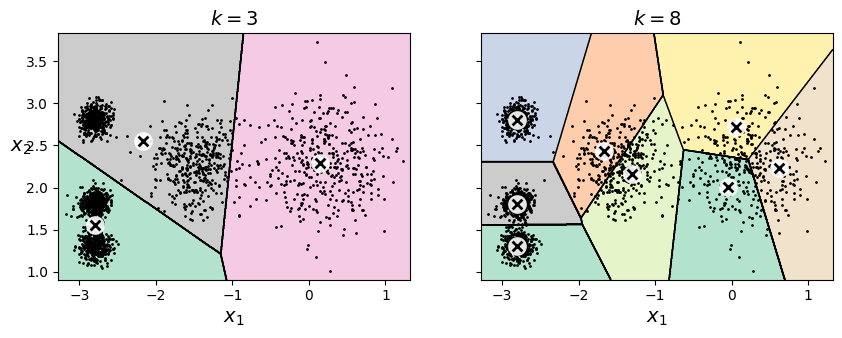

In [32]:
kmeans_k3 = KMeans(n_clusters=3)
kmeans_k8 = KMeans(n_clusters=8)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

In [33]:
kmeans_k3.inertia_

657.2636468168266

In [34]:
kmeans_k8.inertia_

122.97321366961822

In [35]:
## try different k values

kmeans_per_k = [KMeans(n_clusters=k).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

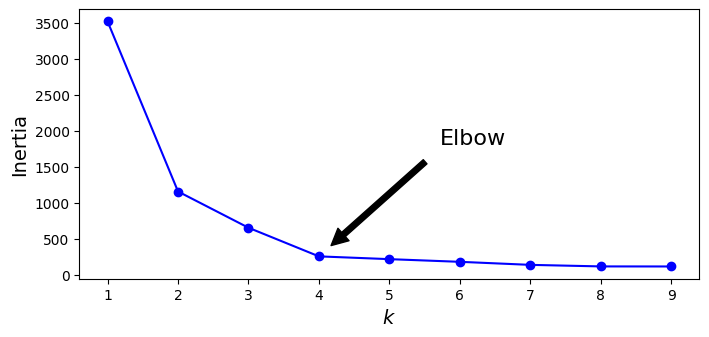

In [36]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
# plt.ylim(0, 1300)
plt.show()

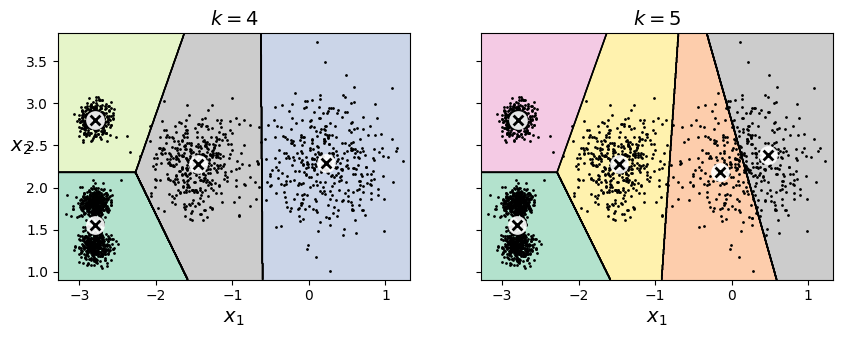

In [37]:
kmeans_k4 = KMeans(n_clusters=4)
kmeans_k5 = KMeans(n_clusters=5)

plot_clusterer_comparison(kmeans_k4, kmeans_k5, X, "$k=4$", "$k=5$")
plt.show()

In [38]:
kmeans_k4.inertia_, kmeans_k5.inertia_

(260.0824303781579, 220.49254846607653)

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

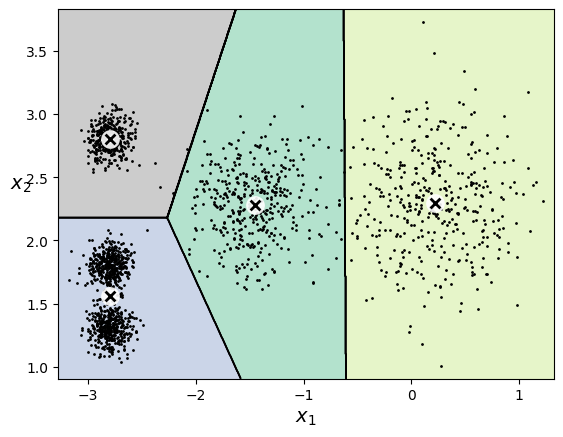

In [39]:
plot_decision_boundaries(kmeans_per_k[3], X)
plt.show()

### Find the optimal number of clusters - the `silhouette score`

The `silhouette score`, which is the mean silhouette coefficient over all the instances. An instance's silhouette coefficient is equal to $\frac{(b - a)}{\max(a, b)}$ where $a$ is the mean distance to the other instances in the same cluster (it is the mean intra-cluster distance), and $b$ is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

![](https://www.researchgate.net/profile/Frans_Coenen/publication/221570710/figure/fig1/AS:670029003644935@1536758771429/Derivation-of-the-Overall-Silhouette-Coefficient-OverallSil.png)

In [40]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

np.float64(0.6316008249403777)

In [41]:
kmeans.get_params

<bound method BaseEstimator.get_params of KMeans(n_clusters=5, random_state=123)>

In [42]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

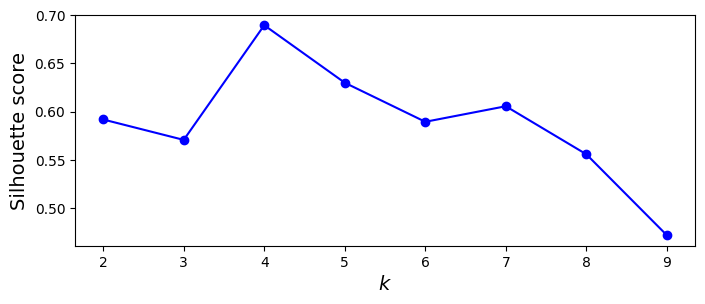

In [43]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

**It confirms that $k=4$ is a very good choice, and it also underlines the fact that $k=5$ is quite good as well, and much better than $k=6$ or $7$.**

## Limit of K-Means model

* Multiple run is needed to avoid suboptimal solutions
* Need to feed in a fixed `k` value
* Doesn't work well when clusters have varying sizes, different densities, or nonspherical shapes
    * It is important to scale the input features before you run the K-Means

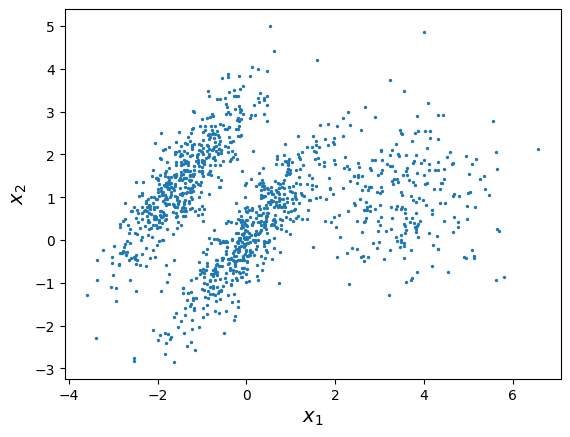

In [44]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plt.scatter(X[:,0], X[:,1], s=2)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.show()

In [48]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=123)
kmeans_bad = KMeans(n_clusters=3, random_state=123)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=123)

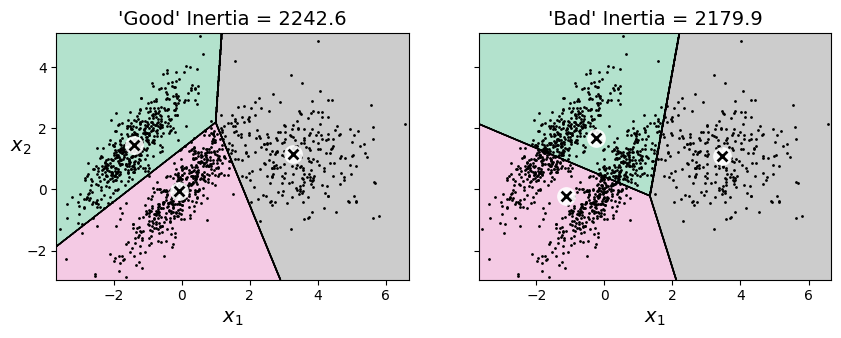

In [49]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("'Good' Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("'Bad' Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

`Gaussian mixture models` works better in this case
* Reference: https://scikit-learn.org/stable/modules/mixture.html